# Generating Visualizations from Data

The following code replicates the data visualizations from the article. Aggregate-level data is provided for replication purposes (in the [`data`](./data/) subdirectory of the directory this notebook is in), but for the purposes of preserving Craigslist user privacy, no individual post-level data is presented in this repository (these often include home street addresses and longitude/latitude values specific to these addresses). All of the code necessary to produce the aggregate-level data used in this notebook on the basis of individual post data, however, is included in [`01_analysis.ipynb`](./01_analysis.ipynb) in this same directory.

## Replication Instructions

This code has been tested in an [Anaconda](https://www.anaconda.com/) Python 3.9 environment and can be replicated (after installing Anaconda) by running the following line of code in a terminal window:

```bash
conda create -n repl_env anaconda==2021.11=py39_0 -y
```

Then, activate the environment (via `conda activate repl_env`) and run the following within the environment to install all of the packages necessary to run the code in this notebook:

```bash
pip install geopandas contextily mapclassify lifelines
```

## Producing Article Figures

Once this notebook has been launched within the environment defined above, we must import in relevant packages, define several functions, and load in data that we will use throughout the notebook.

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import json
import mapclassify
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

city_labels = {
 'boston': 'Boston',
 'newyork': 'New York', 
 'philadelphia': 'Philadelphia',
 'washingtondc': 'Washington D.C.',
 'raleigh': 'Raleigh',
 'atlanta': 'Atlanta',
 'miami': 'Miami',
 'detroit': 'Detroit',
 'chicago': 'Chicago',
 'minneapolis': 'Minneapolis',
 'dallas': 'Dallas',
 'austin': 'Austin',
 'houston': 'Houston',
 'denver': 'Denver',
 'phoenix': 'Phoenix',
 'lasvegas': 'Las Vegas',
 'losangeles': 'Los Angeles',
 'orangecounty': 'Orange County',
 'sandiego': 'San Diego',
 'sfbay': 'San Francisco',
 'sacramento': 'Sacramento',
 'portland': 'Portland',
 'seattle': 'Seattle'
}

def label_cities(row):
    # base case for text position in relation to circular marker
    text_position = (8, -3)

    # adjust text position for several cities
    if row.city == 'orangecounty':
        text_position = (-78,-11)
    elif row.city == 'losangeles':
        text_position = (5,5)
    elif row.city == 'austin':
        text_position = (8, 2)

    # Annotate map with city label
    ax.annotate(text=city_labels[row.city], 
                  xy=(row.geometry.x, row.geometry.y), 
                  xytext=text_position, 
                  textcoords="offset points")


def compare_spatial_dist(erasure_gdf, non_erasure_gdf, town_poly_shp):
    # Compares spatial distribution differences between posts that have
    # not been erased and those that have (or, alternatively, the overall
    # distribution of all posts posted erased + not erased)
    erasure_by_town = gpd.sjoin(erasure_gdf, 
                                town_poly_shp, 
                                predicate='within') \
                         .groupby('index_right') \
                         .geometry \
                         .count() \
                         .rename('erasure_count')
    non_erasure_by_town = gpd.sjoin(non_erasure_gdf,
                                    town_poly_shp, 
                                    predicate='within') \
                             .groupby('index_right') \
                             .geometry \
                             .count() \
                             .rename('non_erasure_count')
    erasure_non_erasure_by_town_merged = town_poly_shp.merge(erasure_by_town,
                                                             left_index=True,
                                                             right_index=True) \
                                                    .merge(non_erasure_by_town,
                                                           how='left', 
                                                           left_index=True, 
                                                           right_index=True)

    ne_sum = erasure_non_erasure_by_town_merged.non_erasure_count.sum()
    e_sum = erasure_non_erasure_by_town_merged.erasure_count.sum()

    erasure_non_erasure_by_town_merged.loc[:, 'ne_pct'] = \
        erasure_non_erasure_by_town_merged.non_erasure_count \
                                          .apply(lambda x: x / ne_sum)
    erasure_non_erasure_by_town_merged.loc[:, 'e_pct'] = \
        erasure_non_erasure_by_town_merged.erasure_count \
                                          .apply(lambda x: x / e_sum)
    erasure_non_erasure_by_town_merged.loc[:, 'ratio'] = \
        erasure_non_erasure_by_town_merged.ne_pct \
        / erasure_non_erasure_by_town_merged.e_pct

    return erasure_non_erasure_by_town_merged

# Load Aggregate Data on Post/Edit Survival from 01_analysis.ipynb
with open('data/survival_data.json') as f:
    data = json.load(f)

# Load State Polygon Data From 2020 Census for producing US map
# https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip
states = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip')
# no data from cities in Alaska, Hawaii, and Puerto Rico, so drop them
states_48 = states[~states['NAME'].isin(['Alaska',
                                         'Hawaii',
                                         'Puerto Rico'])]

# If have individual post-level latitude/longitude data,
# identify how many of these posts fall in each town Polygon
# in a region (here, Boston, as a case study)
try:
    # Town Polygons in MA ("County Subdivisions" as per the Census Bureau) from:
    # https://www.mass.gov/info-details/massgis-data-2020-us-census-towns
    # https://s3.us-east-1.amazonaws.com/download.massgis.digital.mass.gov/shapefiles/census2020/CENSUS2020TOWNS_SHP.zip
    mass_towns = gpd.read_file('data/CENSUS2020TOWNS_SHP/CENSUS2020TOWNS_POLY.shp') \
                    .to_crs(epsg=3857)
    
    # all posts that were erased during study period in Boston area
    erasure_boston = pd.read_csv('data/erasure_boston.csv', 
                             header=None,
                             names=['hours_active', 'time_posted', 'latitude', 'longitude', 'category'])

    erasure_boston_gdf = gpd.GeoDataFrame(
        erasure_boston, geometry=gpd.points_from_xy(erasure_boston.longitude, erasure_boston.latitude), crs='EPSG:4326'
    ).to_crs(epsg=3857)

    # all posts that were not erased during study period in Boston area
    non_erasure_boston = pd.read_csv('data/non_erasure_boston.csv', 
                                    header=None,
                                    names=['hours_active', 'time_posted', 'latitude', 'longitude', 'category'])

    non_erasure_boston_gdf = gpd.GeoDataFrame(
        non_erasure_boston, geometry=gpd.points_from_xy(non_erasure_boston.longitude, non_erasure_boston.latitude), crs='EPSG:4326'
    ).to_crs(epsg=3857)
    non_erasure_boston_gdf = non_erasure_boston_gdf[~((non_erasure_boston.latitude < 41) | (non_erasure_boston.longitude < -80))]

    # Compare non_erasures to overall posts by town to see extent to which March 1st palimpsest represents the aggregate
    overall_boston_gdf = gpd.GeoDataFrame(pd.concat([erasure_boston_gdf, non_erasure_boston_gdf]))
    compare_proportions_overall = \
        compare_spatial_dist(overall_boston_gdf, non_erasure_boston_gdf, mass_towns)
    compare_proportions_overall.to_file('data/shp_files/boston_agg.shp')
    
    # Do the same for different object categories:
    compare_proportions = {}
    for cat in ['pet', 'electronics', 'furniture', 'kitchen']:
        compare_proportions[cat] = \
            compare_spatial_dist(
                overall_boston_gdf[overall_boston_gdf.category == cat],
                non_erasure_boston_gdf[non_erasure_boston_gdf.category == cat],
                mass_towns)
        compare_proportions[cat].to_file('data/shp_files/boston_agg_{}.shp'.format(cat))

except:
    # If don't have individual-level data (not included in this repository),
    # Then, read in the data aggregated via the code above for further analysis:
    compare_proportions_overall = gpd.read_file('data/shp_files/boston_agg.shp')
    compare_proportions = {}
    for cat in ['pet', 'electronics', 'furniture', 'kitchen']:
        compare_proportions[cat] = \
            gpd.read_file('data/shp_files/boston_agg_{}.shp'.format(cat))

### Figure 2: Percentage of February 2023 Posts erased by March 1, 2023, aggregated by city.

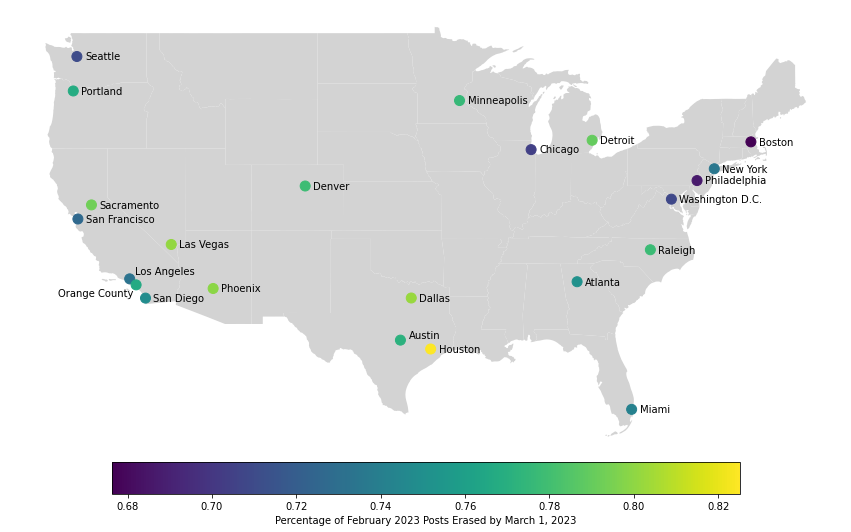

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
states_48.plot(color='lightgrey',
                    figsize=(15, 10),
                    ax=ax)

pct_erased_by_city = pd.DataFrame(data['fig2'])
pct_erased_by_city_gdf = gpd.GeoDataFrame(
    pct_erased_by_city,
    geometry=gpd.points_from_xy(pct_erased_by_city.longitude,
                                pct_erased_by_city.latitude),
    crs='EPSG:4326'
)

pct_erased_by_city_gdf.plot(ax=ax,
                            markersize=100,
                            cmap='viridis',
                            column='pct_erased',
                            legend=True,
                            legend_kwds={'shrink': 0.75,
                                         'orientation': 'horizontal',
                                         'label': 'Percentage of February 2023 Posts Erased by March 1, 2023',
                                         'pad': 0.01})\
                      .set_axis_off()

pct_erased_by_city_gdf.apply(label_cities, axis=1)

# save to file
plt.savefig('figure2.pdf', dpi=300, format="pdf", bbox_inches="tight")


### Figure 3: Modeling Overall Post Hours-to-erasure

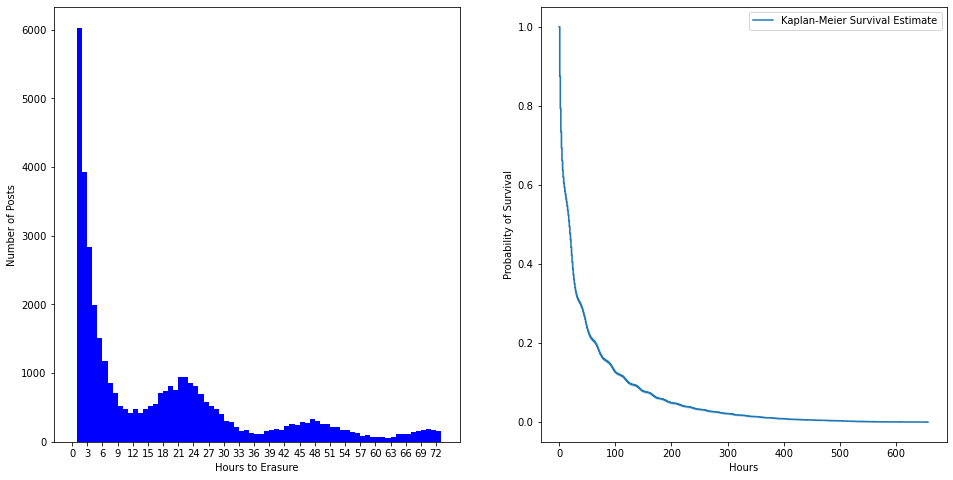

In [6]:
binSides, binCounts = data['fig3']
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Left Subplot: Overall Hours-to-Erasure Histogram
l_counts_subset = binCounts[:(3 * 24 + 1)]
l_sides_subset = binSides[:(3 * 24 + 2)]
N = len(l_counts_subset)
ind = np.arange(N)
width = 1
rects1 = ax[0].bar(ind + 0.5, l_counts_subset, width, color='b')
ax[0].set_xlabel('Hours to Erasure')
ax[0].set_ylabel('Number of Posts')
ax[0].set_xticks(np.arange(0, 3 * 24 + 1, 3))
ax[0].set_xticklabels(np.arange(0, 3 * 24 + 1, 3))

# Right Subplot: KM Survival Curve
durations_overall = np.repeat(binSides[:-1], binCounts)
kmf.fit(durations_overall)
kmf.plot(ax=ax[1], 
         label='Kaplan-Meier Survival Estimate', 
         xlabel='Hours', 
         ylabel='Probability of Survival')

# save to file
plt.savefig('figure3.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 4: Number of Posts Surviving through March 1, 2023, compared with the total number of new posts each day in February 2023.

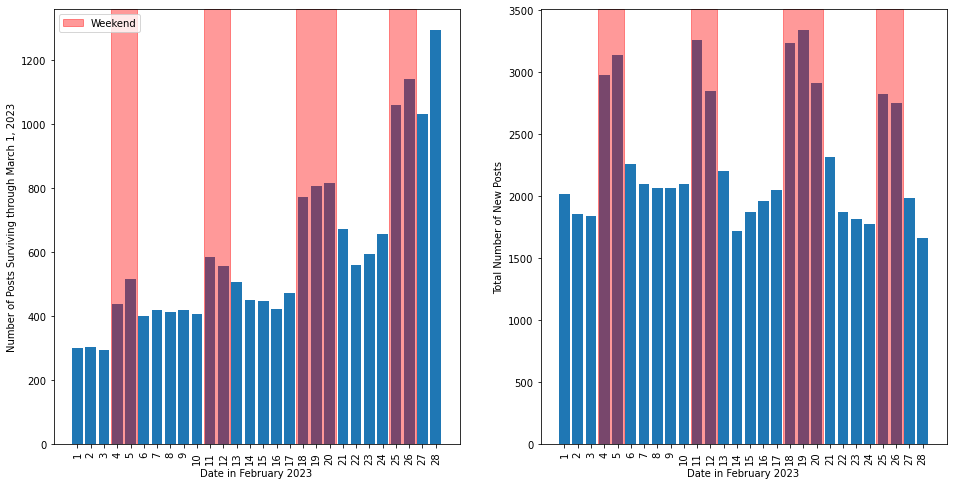

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Left Subplot: Non-erased Overall Counts by Day
binSides, binCounts = data['fig4_l']
N = len(binCounts)
ind = np.arange(1, N + 1)

ax[0].bar(ind, binCounts[::-1])
ax[0].set_ylabel('Number of Posts Surviving through March 1, 2023')
ax[0].set_xticks(ind)
ax[0].set_xticklabels(ind, rotation=90)
ax[0].set_xlabel('Date in February 2023')

# Right Subplot: Total Number of posts by day in February 
overall_posts_by_day = data['fig4_r']

ax[1].bar(ind, overall_posts_by_day[::-1])
ax[1].set_ylabel('Total Number of New Posts')
ax[1].set_xticks(ind)
ax[1].set_xticklabels(ind, rotation=90)
ax[1].set_xlabel('Date in February 2023')

# Highlight weekends in both subplots; Note that Feb 20th was a Federal Holiday
# (Presidents Day), making Feb 18-20th a 3-day weekend
weekends = [(4, 5), (11, 12), (18, 20), (25, 26)]
for i, we in enumerate(weekends):
    ax[0].axvspan(we[0] - 0.5, we[1] + 0.5, color='r', alpha=0.4,
                  label='_'*i + 'Weekend')
    ax[1].axvspan(we[0] - 0.5, we[1] + 0.5, color='r', alpha=0.4)
ax[0].legend()

# save to file
plt.savefig('figure4.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 5: Comparing the spatial distribution of surviving items overall on March 1, 2023 to the spatial distribution of all items posted in the preceding month

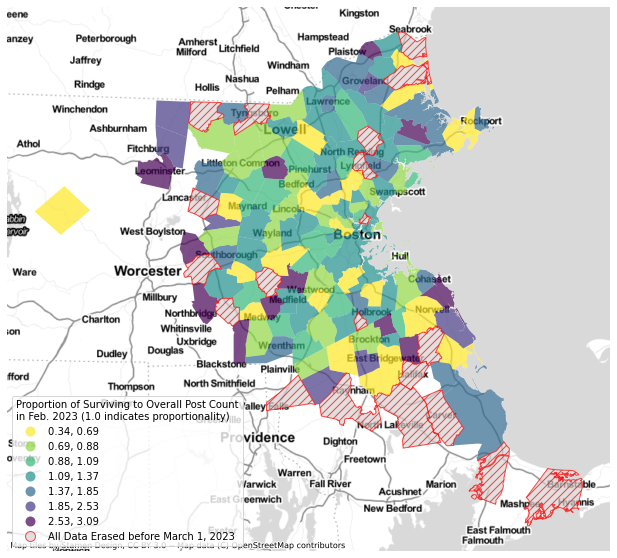

In [8]:
ax = compare_proportions_overall.plot(
        column='ratio',
        cmap='viridis_r',
        scheme='natural_breaks',
        k=7,
        figsize=(15,10),
        alpha=0.7,
        legend=True,
        legend_kwds={
            'loc': 'lower left',
            'title': 'Proportion of Surviving to Overall Post Count\nin Feb. 2023 (1.0 indicates proportionality)'
        },
        missing_kwds={
        'color': 'lightgrey',
        'edgecolor': 'red',
        'hatch': '///',
        'label': 'All Data Erased before March 1, 2023'
        }
)

cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
ax.set_axis_off()

# save to file
plt.savefig('figure5.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 6: Regional KM Survival Curves

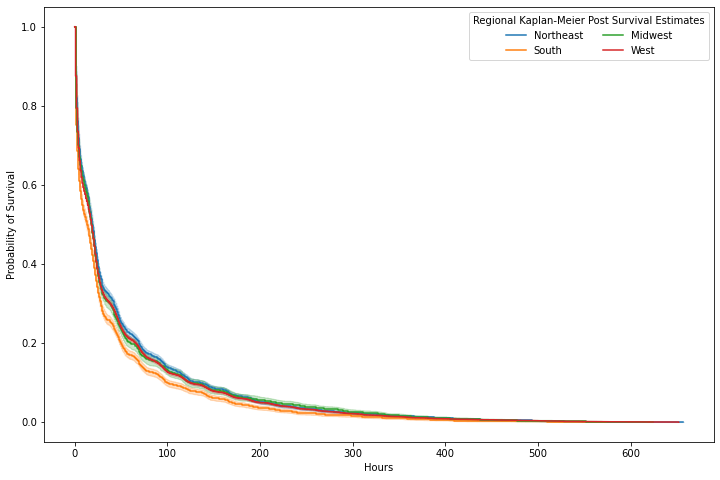

In [9]:
pdf_cats_city_region = pd.DataFrame(data['fig6_7'])

fig, ax = plt.subplots(figsize=(12, 8))

regions = ['northeast', 'south', 'midwest', 'west']
for r in regions:
    r_df = pdf_cats_city_region[pdf_cats_city_region['region'] == r]
    kmf.fit(r_df['hours_active'], label=r.capitalize())
    kmf.plot(ax=ax, xlabel='Hours', ylabel='Probability of Survival')

ax.legend(title='Regional Kaplan-Meier Post Survival Estimates', ncol=2)

# save to file
plt.savefig('figure6.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 7: Categorical KM Post Survival Curves

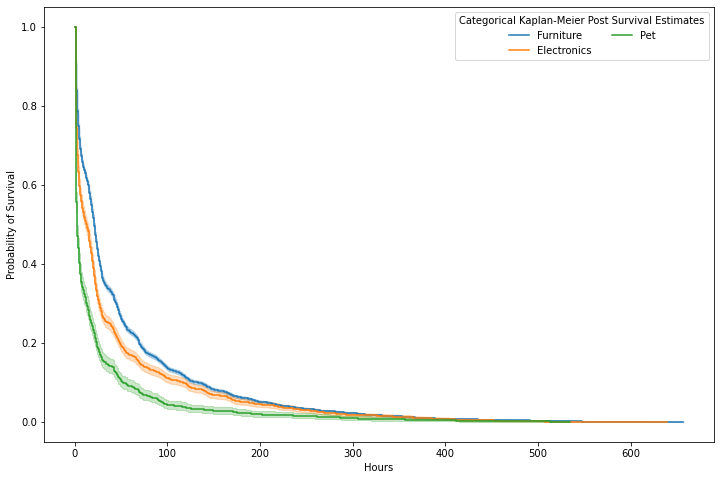

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

categories = ['furniture', 'electronics', 'pet']
for cat in categories:
    c_df = pdf_cats_city_region[pdf_cats_city_region['top_category'] == cat]
    kmf.fit(c_df['hours_active'], label=cat.capitalize())
    kmf.plot(ax=ax, xlabel='Hours', ylabel='Probability of Survival')

ax.legend(title='Categorical Kaplan-Meier Post Survival Estimates', ncol=2)

# save to file
plt.savefig('figure7.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 8: Comparing the spatial distribution (by category) of surviving items on March 1, 2023 to the spatial distribution of all items posted in the preceding month

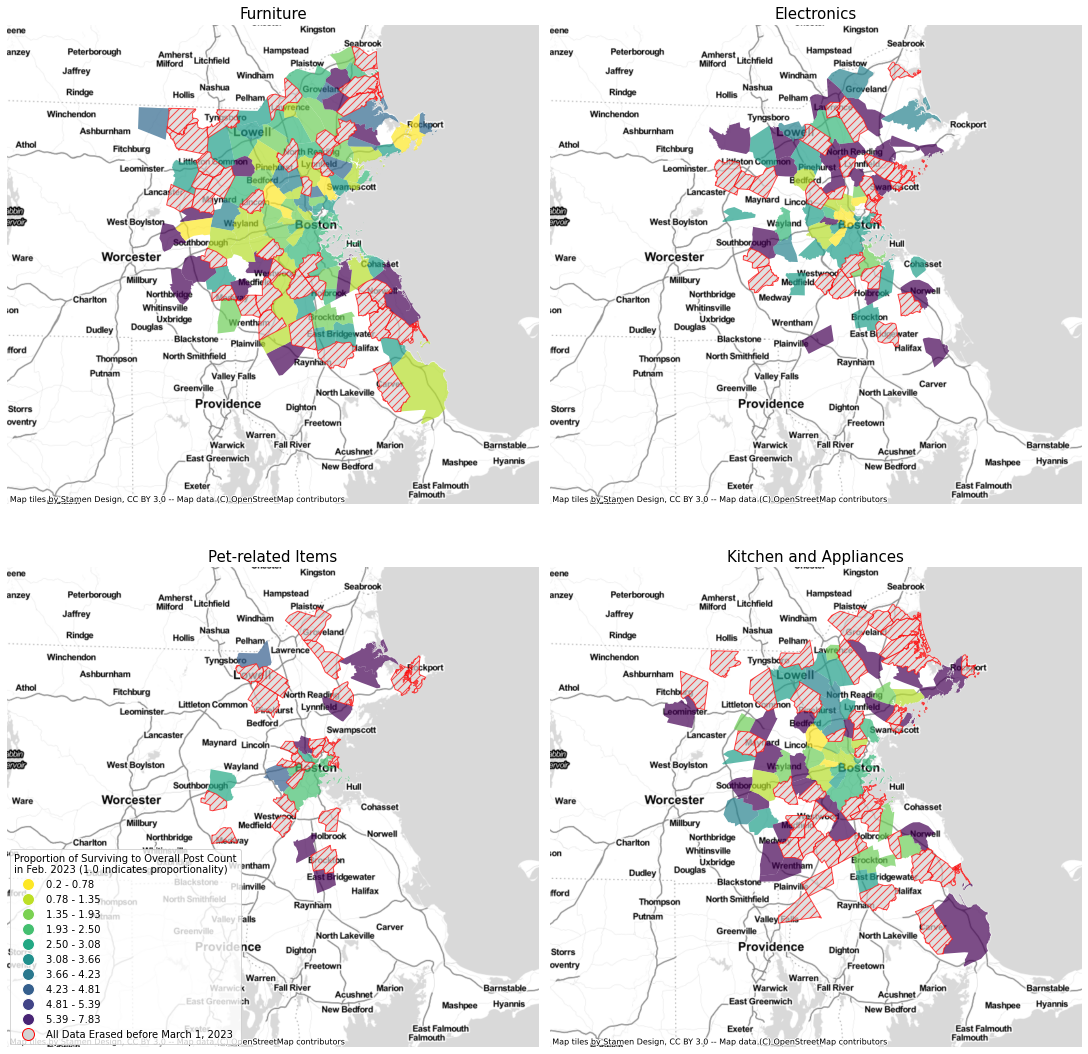

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15),
                       constrained_layout=True)
ax = ax.ravel()

gdf_dict = {'Furniture': compare_proportions['furniture'],
            'Electronics': compare_proportions['electronics'],
            'Pet-related Items': compare_proportions['pet'],
            'Kitchen and Appliances': compare_proportions['kitchen']
}

bins = mapclassify.EqualInterval(gdf_dict['Furniture']['ratio'], k=10).bins

for i, k in enumerate(gdf_dict.keys()):
    minx, maxx = (-8048669.1898469515, -7810438.688961195)
    ax[i].set_xlim(minx, maxx)
    miny, maxy = (5089633.422959745, 5304521.805669296)
    ax[i].set_ylim(miny, maxy)

    gdf_dict[k].plot(ax=ax[i],
                     figsize=(10,10),
                     column='ratio',
                     cmap='viridis_r',
                     scheme='user_defined',
                     k=10,
                     classification_kwds=dict(bins=list(bins)),
                     alpha=0.7,
                     missing_kwds={
                        'color': 'lightgrey',
                        'edgecolor': 'red',
                        'hatch': '///',
                     }
    )

    cx.add_basemap(ax[i], source=cx.providers.Stamen.TonerLite)
    ax[i].set_axis_off()
    ax[i].set_title(str(k), size=15)

cmap = cm.get_cmap('viridis_r')

# Create custom legend mapping onto color map levels
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='0.2 - 0.78',
           markerfacecolor=cmap(0.0), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='0.78 - 1.35',
           markerfacecolor=cmap(0.1), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='1.35 - 1.93',
           markerfacecolor=cmap(0.2), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='1.93 - 2.50',
           markerfacecolor=cmap(0.3), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='2.50 - 3.08',
           markerfacecolor=cmap(0.4), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='3.08 - 3.66',
           markerfacecolor=cmap(0.5), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='3.66 - 4.23',
           markerfacecolor=cmap(0.6), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='4.23 - 4.81',
           markerfacecolor=cmap(0.7), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='4.81 - 5.39',
           markerfacecolor=cmap(0.8), markersize=12),
    Line2D([0], [0], marker='o', color='w', label='5.39 - 7.83',
           markerfacecolor=cmap(0.9), markersize=12),
    Line2D([0], [0], marker='o', color='red',
           label='All Data Erased before March 1, 2023',
           markerfacecolor='lightgrey', markersize=12, linestyle='')
]

fig.legend(handles=legend_elements,
           loc='lower left', 
           title='Proportion of Surviving to Overall Post Count\nin Feb. 2023 (1.0 indicates proportionality)',
           bbox_to_anchor=[0.001, 0.025])

# save to file
plt.savefig('figure8.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 9: Overall KM Edit Survival Curve

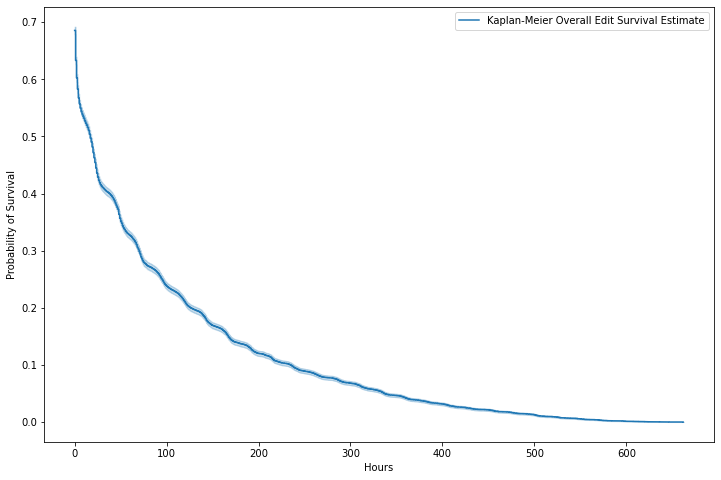

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))

time_to_edit_hist_bins = data['fig9']
durations_overall = np.repeat(time_to_edit_hist_bins[0][:-1],
                              time_to_edit_hist_bins[1])
kmf.fit(durations_overall, label='Kaplan-Meier Overall Edit Survival Estimate')
kmf.plot(ax=ax, xlabel='Hours', ylabel='Probability of Survival')

# save to file
plt.savefig('figure9.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 11: Regional KM Edit Survival Curves

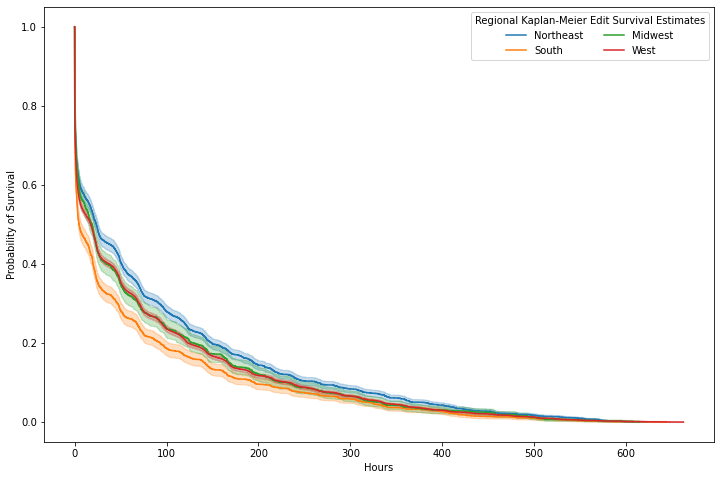

In [13]:
pdf_cats_city_region_edit = pd.DataFrame(data['fig11_12'])

fig, ax = plt.subplots(figsize=(12, 8))
for r in regions:
    region_mask = pdf_cats_city_region_edit['region'] == r
    kmf.fit(pdf_cats_city_region_edit[region_mask]['duration'], 
            label=r.capitalize())
    kmf.plot(ax=ax, xlabel='Hours', ylabel='Probability of Survival')

ax.legend(title='Regional Kaplan-Meier Edit Survival Estimates', ncol=2)

# save to file
plt.savefig('figure11.pdf', dpi=300, format="pdf", bbox_inches="tight")

### Figure 12: Categorical KM Edit Survival Curves

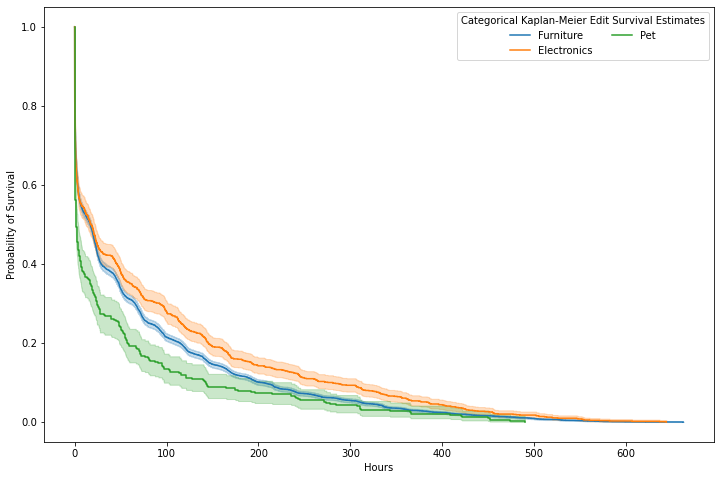

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
for cat in categories:
    cat_mask = pdf_cats_city_region_edit['top_category'] == cat
    c_df = pdf_cats_city_region_edit['duration'][cat_mask]
    kmf.fit(c_df, label=cat.capitalize())
    kmf.plot(ax=ax, xlabel='Hours', ylabel='Probability of Survival')

ax.legend(title='Categorical Kaplan-Meier Edit Survival Estimates', ncol=2)

# save to file
plt.savefig('figure12.pdf', dpi=300, format="pdf", bbox_inches="tight")